# 1.   Восстановление золота из руды

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
<br><br>Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 
<br><br>Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
<br><br>Нам нужно:
    
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.</div>

## 1.1.   Подготовка данных

### 1.1.1.   Импорты и чтение файлов

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
gr_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
gr_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gr_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### 1.1.2.   Знакомство с данными

### 1.1.3.   Расчет эффективности обогащения

In [3]:
# для формулы (C * (F - T)) / (F * (C - T)) * 100 
# создадим отдельные переменные, с соответствующими данными

C = gr_train['rougher.output.concentrate_au']
F = gr_train['rougher.input.feed_au']
T = gr_train['rougher.output.tail_au']

In [4]:
# расчитанные по формуле значения сохраним в отдельную переменную
Recovery = (C * (F - T)) / (F * (C - T)) * 100

In [5]:
# проверим отклонение по Mean Absolute Error
mae(Recovery, gr_train['rougher.output.recovery'])

9.73512347450521e-15

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Крайне малое значение, погрешностью которого (при согласии исследователей) можно пренебречь – Python и на более низких разрядах ошибается (особенно при делении нецелых чисел)</div>

In [6]:
# 0.3 / 0.1

### 1.1.4.   Признаки тестовой выборки

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Посмотрим на признаки набора, не вошедшие в тестовую выборку</div>

In [7]:
[col 
 for col in gr_full.columns 
 if col not in gr_test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
В основном видны output - можно сделать вывод, что результативные данные подтягиваются позже, и мы, скорее всего, окажемся в ситуации, где у нас не будет этих данных при реальных предсказаниях</div>

## 1.2.   Анализ данных

### 1.2.1.   Поэтапное изменение концентраций

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Рассмотрим три объекта – концентрацию au, ag и pb. Также для наблюдения возьмем три этапа: черновой концентрат (после флотации), состояние после первичной очистки и финальное состояние (после вторичной очистки). Рассматривать будем распределения этих показателей</div>

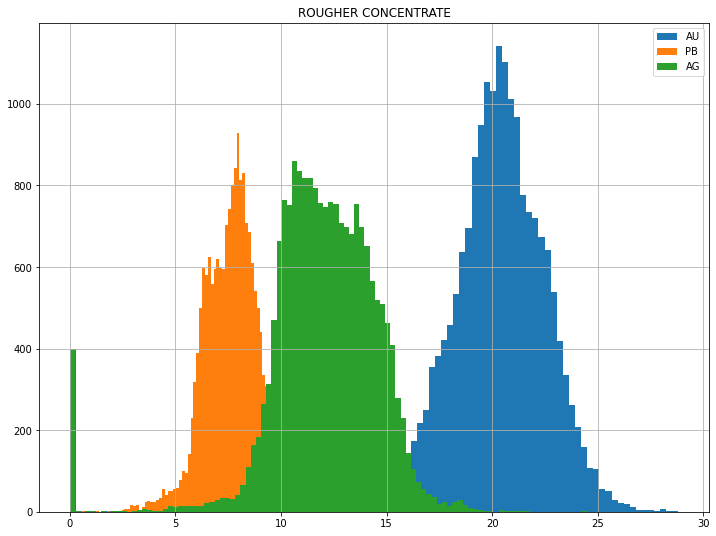

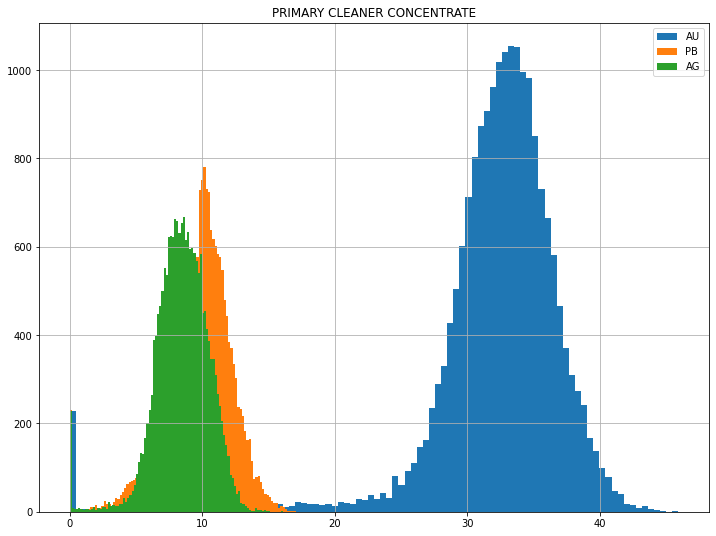

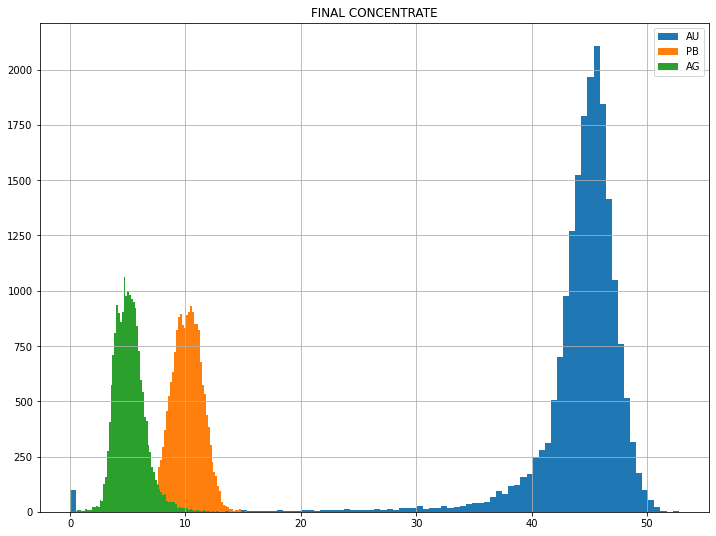

In [8]:
plt.figure(figsize=(12, 9))
gr_full['rougher.output.concentrate_au'].hist(bins=100, label='AU')
gr_full['rougher.output.concentrate_pb'].hist(bins=100, label='PB')
gr_full['rougher.output.concentrate_ag'].hist(bins=100, label='AG')
plt.title('ROUGHER CONCENTRATE')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
gr_full['primary_cleaner.output.concentrate_au'].hist(bins=100, label='AU')
gr_full['primary_cleaner.output.concentrate_pb'].hist(bins=100, label='PB')
gr_full['primary_cleaner.output.concentrate_ag'].hist(bins=100, label='AG')
plt.title('PRIMARY CLEANER CONCENTRATE')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
gr_full['final.output.concentrate_au'].hist(bins=100, label='AU')
gr_full['final.output.concentrate_pb'].hist(bins=100, label='PB')
gr_full['final.output.concentrate_ag'].hist(bins=100, label='AG')
plt.title('FINAL CONCENTRATE')
plt.legend()
plt.show()

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь видно, что au, концентрация которого нам в конечном итоге и важна, возрастает и в абсолютном выражении, и как концентрация, в частях
<br><br>Значения pb остаются примерно на одном месте, ag, в свою очередь, незначительно уменьшается</div>

### 1.2.2.   Распределение размеров гранул сырья

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Построим boxplot</div>

<AxesSubplot:>

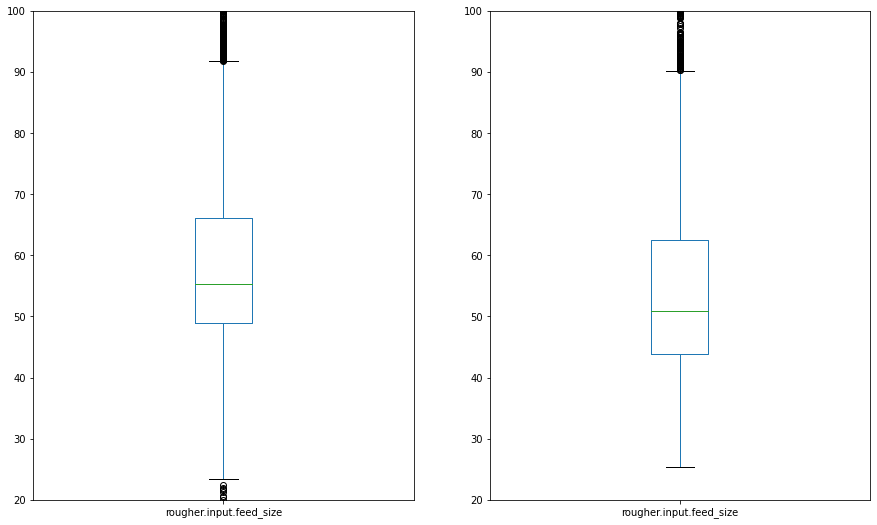

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 9))
gr_train['rougher.input.feed_size'].plot(kind='box', ax=ax1, ylim=(20, 100))
gr_test['rougher.input.feed_size'].plot(kind='box', ax=ax2, ylim=(20, 100))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Распределения очень похожи, сильных отличий (в масштабах данных) не наблюдается</div>

<AxesSubplot:>

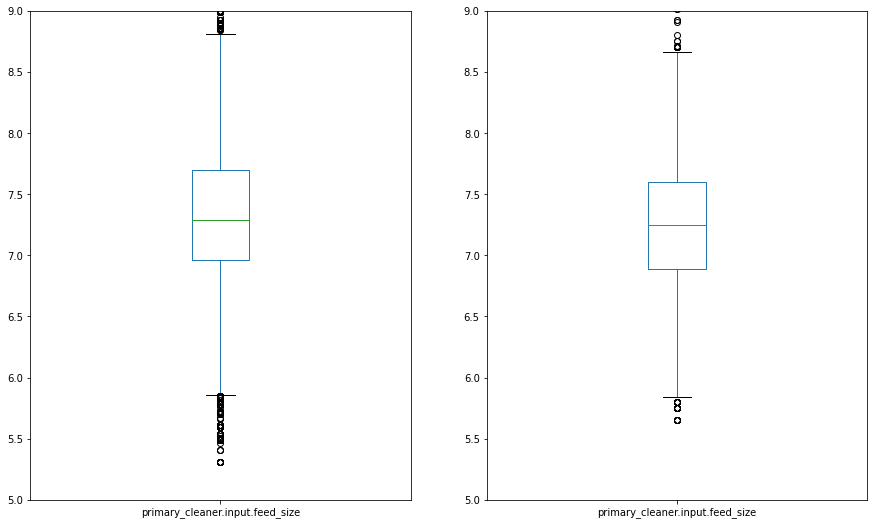

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 9))
gr_train['primary_cleaner.input.feed_size'].plot(kind='box', ax=ax1, ylim=(5, 9))
gr_test['primary_cleaner.input.feed_size'].plot(kind='box', ax=ax2, ylim=(5, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь примерно та же история – выбросы иногда отличаются, но большая часть данных лежит в одинаковых пределах</div>

### 1.2.3.   Концентрация на разных стадиях

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Можно посмотреть отдельно каждый элемент по этапам</div>

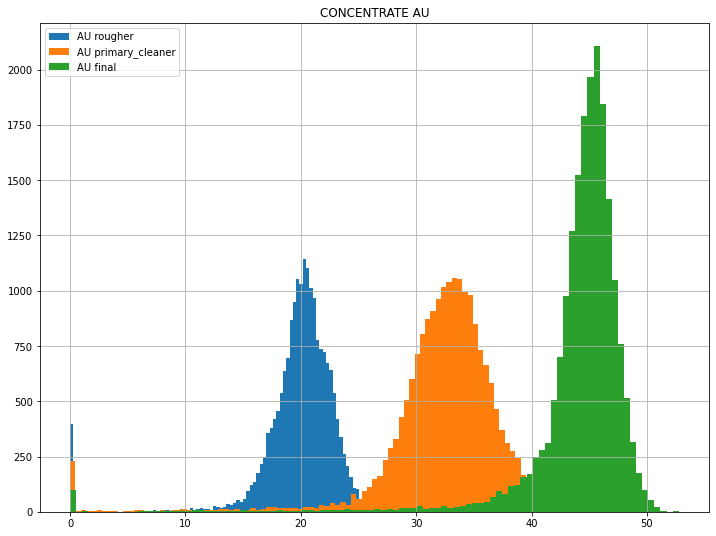

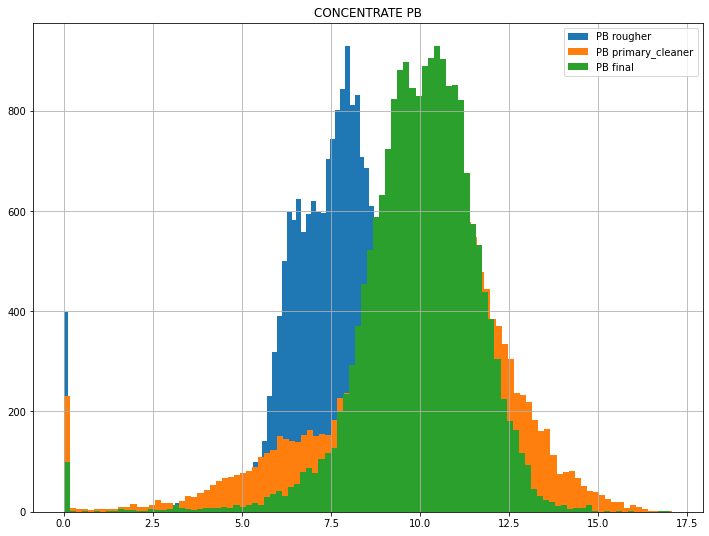

In [11]:
plt.figure(figsize=(12, 9))
gr_full['rougher.output.concentrate_au'].hist(bins=100, label='AU rougher')
gr_full['primary_cleaner.output.concentrate_au'].hist(bins=100, label='AU primary_cleaner')
gr_full['final.output.concentrate_au'].hist(bins=100, label='AU final')
plt.title('CONCENTRATE AU')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
gr_full['rougher.output.concentrate_pb'].hist(bins=100, label='PB rougher')
gr_full['primary_cleaner.output.concentrate_pb'].hist(bins=100, label='PB primary_cleaner')
gr_full['final.output.concentrate_pb'].hist(bins=100, label='PB final')
plt.title('CONCENTRATE PB')
plt.legend()
plt.show()

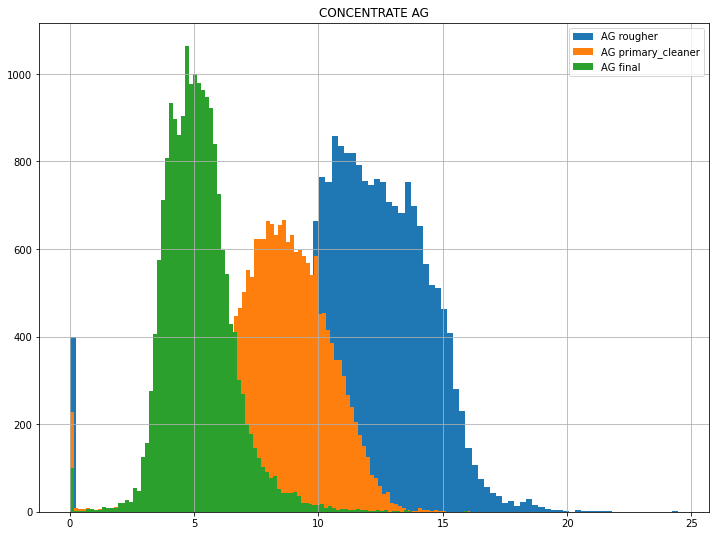

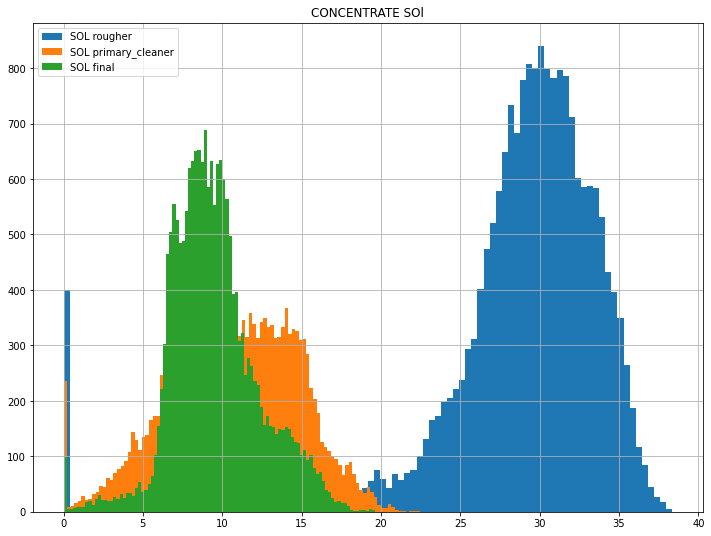

In [12]:
plt.figure(figsize=(12, 9))
gr_full['rougher.output.concentrate_ag'].hist(bins=100, label='AG rougher')
gr_full['primary_cleaner.output.concentrate_ag'].hist(bins=100, label='AG primary_cleaner')
gr_full['final.output.concentrate_ag'].hist(bins=100, label='AG final')
plt.title('CONCENTRATE AG')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
gr_full['rougher.output.concentrate_sol'].hist(bins=100, label='SOL rougher')
gr_full['primary_cleaner.output.concentrate_sol'].hist(bins=100, label='SOL primary_cleaner')
gr_full['final.output.concentrate_sol'].hist(bins=100, label='SOL final')
plt.title('CONCENTRATE SOl')
plt.legend()
plt.show()

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
На графиках с уже одинаковым масштабом можно заметить резкий рост au на последней стадии, рост ag, практически неизменную концентрацию pb и значительный спад sol</div>

In [13]:
# для каждого этапа пропишем необходимые названия колонок концентрации
primary_cleaner_concentrate = ['primary_cleaner.output.concentrate_ag',
                               'primary_cleaner.output.concentrate_pb',
                               'primary_cleaner.output.concentrate_sol',
                               'primary_cleaner.output.concentrate_au']

final_concentrate = ['final.output.concentrate_ag', 
                     'final.output.concentrate_pb',
                     'final.output.concentrate_sol', 
                     'final.output.concentrate_au']

rougher_concentrate = ['rougher.output.concentrate_ag',
                       'rougher.output.concentrate_pb', 
                       'rougher.output.concentrate_sol',
                       'rougher.output.concentrate_au']

# положим все в один словарь
full_concentrate = {'rougher': rougher_concentrate, 
                    'primary': primary_cleaner_concentrate, 
                    'final': final_concentrate}

In [14]:
# создадим списки для хранения данных каждого вещества
ag, pb, sol, au, full = [], [], [], [], []

for step in full_concentrate:
    # сохраним средние данные по веществам
    concentrate = gr_full[full_concentrate[step]].mean()
    # выведем суммарную концентрацию всех веществ
    print(f'{step}: {concentrate.sum()}')
    # и каждого в отдельности
    print(f'ag: {round(concentrate[0], 2)} ({round(concentrate[0] / concentrate.sum() *100, 2)}%)\n'
          f'pb: {round(concentrate[1], 2)} ({round(concentrate[1] / concentrate.sum() *100, 2)}%)\n'
          f'sol: {round(concentrate[2], 2)} ({round(concentrate[2] / concentrate.sum() *100, 2)}%)\n'
          f'au: {round(concentrate[3], 2)} ({round(concentrate[3] / concentrate.sum() *100, 2)}%)\n')
    
    # заполним списки
    ag.append(round(concentrate[0], 2))
    pb.append(round(concentrate[1], 2))
    sol.append(round(concentrate[2], 2))
    au.append(round(concentrate[3], 2))
    full.append(concentrate.sum())

rougher: 68.17860254823096
ag: 11.99 (17.59%)
pb: 7.61 (11.16%)
sol: 28.81 (42.25%)
au: 19.77 (29.0%)

primary: 60.88083772573897
ag: 8.44 (13.87%)
pb: 9.83 (16.15%)
sol: 10.49 (17.23%)
au: 32.12 (52.76%)

final: 68.72510242280688
ag: 5.17 (7.52%)
pb: 9.98 (14.52%)
sol: 9.5 (13.82%)
au: 44.08 (64.13%)



<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь такая же картина - концентрация золота растет, остальные либо падают, либо остаются в пределах погрешности</div>

## 1.3.   Модель

### 1.3.1.   sMAPE

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Напишем функцию, вычисляющую sMAPE</div>

In [15]:
def sMAPE(target, predicted):
    N = len(target)
    y = pd.Series(target)
    y_ = pd.Series(predicted)
    numerator = abs(y - y_)
    denominator = (abs(y) + abs(y_)) / 2 
    return (numerator / denominator).sum() / N * 100

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
На основе этой функции, напишем функцию, вычисляющую итоговое sMAPE</div>

In [16]:
def final_sMAPE(rougher_target, rougher_predicted, final_target, final_predicted):
    return 0.25 * sMAPE(rougher_target, rougher_predicted) + 0.75 * sMAPE(final_target, final_predicted)

### 1.3.2.   Преподготовка

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Так как в тестовой выборке отсутствуют целевые признаки, для оценки работы лучшей модели необходимо их туда подтянуть</div>

In [17]:
gr_test_added = (gr_test
                 .merge(gr_full[['date', 'rougher.output.recovery']], on='date')
                 .merge(gr_full[['date', 'final.output.recovery']], on='date'))

In [18]:
gr_test_added.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Также пропишем функцию для кросс-валидации</div>

In [19]:
def cross_val(model, X, y, cv=3):
    scores = []
    kf = KFold(n_splits=cv)
    kf.get_n_splits(y)
    for train_index, test_index in kf.split(y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train)
        scores.append(sMAPE(y_test, model.predict(X_test)))
    return pd.Series(scores).mean()

### 1.3.3.   Прогнозирование

#### 1.3.3.1.   Rougher Output Recovery

##### 1.3.3.1.1.   Анализ колонок

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
На первом шаге нас интересует rougher.output.recovery – результат флотации. Таким образом, чтобы предсказывать его, нам доступны только данные, идущие ДО этого этапа: 
<br><br>- 'rougher.calculation.sulfate_to_au_concentrate'
<br><br>- 'rougher.calculation.floatbank10_sulfate_to_au_feed'
<br><br>- 'rougher.calculation.floatbank11_sulfate_to_au_feed'
<br><br>- 'rougher.calculation.au_pb_ratio'
<br><br>- 'rougher.input.feed_ag'
<br><br>- 'rougher.input.feed_pb'
<br><br>- 'rougher.input.feed_rate'
<br><br>- 'rougher.input.feed_size'
<br><br>- 'rougher.input.feed_sol'
<br><br>- 'rougher.input.feed_au'
<br><br>- 'rougher.input.floatbank10_sulfate'
<br><br>- 'rougher.input.floatbank10_xanthate'
<br><br>- 'rougher.input.floatbank11_sulfate'
<br><br>- 'rougher.input.floatbank11_xanthate'
<br><br>- 'rougher.output.concentrate_ag'
<br><br>- 'rougher.output.concentrate_pb' 
<br><br>- 'rougher.output.concentrate_sol'
<br><br>- 'rougher.output.concentrate_au'
<br><br>
<br><br>Немного очистив данные, выкинув результаты других показателей, а также рассчеты, получим следующий набор признаков:
<br><br>- 'rougher.input.feed_ag'
<br><br>- 'rougher.input.feed_pb'
<br><br>- 'rougher.input.feed_rate'
<br><br>- 'rougher.input.feed_size'
<br><br>- 'rougher.input.feed_sol'
<br><br>- 'rougher.input.feed_au'
<br><br>- 'rougher.input.floatbank10_sulfate'
<br><br>- 'rougher.input.floatbank10_xanthate'
<br><br>- 'rougher.input.floatbank11_sulfate'
<br><br>- 'rougher.input.floatbank11_xanthate'
<br><br>
<br><br>Собственно, все, что подается на вход</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Оставим только те колонки, которые есть в тестовой выборке</div>

In [20]:
train_columns_rougher = ['rougher.input.feed_ag', 'rougher.input.feed_pb',
                         'rougher.input.feed_rate', 'rougher.input.feed_size',
                         'rougher.input.feed_sol', 'rougher.input.feed_au',
                         'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                         'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']

result_columns_rougher = []
for column in train_columns_rougher:
    if column in gr_test:
        result_columns_rougher.append(column)
    else:
        print(column)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Собственно, остались все, но лишним такой маневр не будет</div>

In [21]:
gr_train = gr_train.dropna().reset_index(drop=True)
gr_train_features_rougher = gr_train[result_columns_rougher]
gr_train_target_rougher = gr_train['rougher.output.recovery']

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Так как данные указывают на регрессию, будем использовать четыре основных регрессора:
<br><br>- LinearRegression
<br><br>- DecisionTreeRegressor
<br><br>- RandomForestRegressor</div>

### LinearRegression

In [22]:
best_Linear_model_rougher = LinearRegression()
print(cross_val(best_Linear_model_rougher, gr_train_features_rougher, gr_train_target_rougher, 3))

3.399688153402923


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Разброс в 3.4% - не самый большой, который мы могли иметь</div>

### DecisionTreeRegressor

In [23]:
best_dtr_model = None
best_dtr_sMAPE = False
best_dtr_depth = 0

for depth in range(1, 21):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dtr_sMAPE = cross_val(model, gr_train_features_rougher, gr_train_target_rougher, 3)
    if not best_dtr_sMAPE:
        best_dtr_sMAPE = dtr_sMAPE
    if dtr_sMAPE < best_dtr_sMAPE:
        best_dtr_model = model
        best_dtr_sMAPE = dtr_sMAPE
        best_dtr_depth = depth

best_dtr_sMAPE, best_dtr_depth

(3.254858242329988, 2)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь разброс чуть ближе к 3.25%, и всего 2 уровня, следовательно – модель плохо подходит для данной задачи</div>

### RandomForestRegressor

In [24]:
best_rfr_model = None
best_rfr_sMAPE = False
best_rfr_depth = 0

for depth in range(1, 6):
    for estimators in range(95, 106, 5):
        model = RandomForestRegressor(n_estimators=estimators, 
                                      max_depth=depth, 
                                      random_state=12345)
        rfr_sMAPE = cross_val(model, gr_train_features_rougher, gr_train_target_rougher, 3)
        if not best_rfr_sMAPE:
            best_rfr_sMAPE = rfr_sMAPE
        if rfr_sMAPE < best_rfr_sMAPE:
            best_rfr_model = model
            best_rfr_sMAPE = rfr_sMAPE
            best_rfr_depth = depth
            best_rfr_estimators = estimators

best_rfr_sMAPE, best_rfr_depth, best_rfr_estimators

(3.3777171547708815, 5, 100)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь примерно так же - 3.4% отклонений и 5 уровней</div>

#### 1.3.3.2.   Final Output Recovery

##### 1.3.3.2.1.   Анализ колонок

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Так как это финальная стадия, добавим к уже существующим колонкам еще несколько:
<br><br>- 'primary_cleaner.input.sulfate'
<br><br>- 'primary_cleaner.input.depressant',
<br><br>- 'primary_cleaner.input.feed_size'
<br><br>- 'primary_cleaner.input.xanthate'</div>

In [25]:
train_columns_final = train_columns_rougher + ['primary_cleaner.input.sulfate',
                                               'primary_cleaner.input.depressant', 
                                               'primary_cleaner.input.feed_size', 
                                               'primary_cleaner.input.xanthate']

result_columns_final = []

for column in train_columns_final:
    if column in gr_test:
        result_columns_final.append(column)
    else:
        print(column)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Все значения вошли</div>

In [26]:
gr_train_features_final = gr_train[result_columns_final]
gr_train_target_final = gr_train['final.output.recovery']

##### 1.3.3.2.2.   LinearRegression

In [27]:
best_Linear_model_final = LinearRegression()
print(cross_val(best_Linear_model_final, gr_train_features_final, gr_train_target_final, 3))

3.1033350486199325


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Значительно ниже - около 3%</div>

##### 1.3.3.2.3.   DecisionTreeRegressor

In [28]:
best_dtr_model = None
best_dtr_sMAPE = False
best_dtr_depth = 0

for depth in range(1, 21):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dtr_sMAPE = cross_val(model, gr_train_features_final, gr_train_target_final, 3)
    if not best_dtr_sMAPE:
        best_dtr_sMAPE = dtr_sMAPE
    if dtr_sMAPE < best_dtr_sMAPE:
        best_dtr_model = model
        best_dtr_sMAPE = dtr_sMAPE
        best_dtr_depth = depth

best_dtr_sMAPE, best_dtr_depth

(2.8392696825809485, 0)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Разброс такой же небольшой, однако видно, что модель отвечала наугад - 0 уровней</div>

##### 1.3.3.2.4.   RandomForestRegressor

In [29]:
best_rfr_model = None
best_rfr_sMAPE = False
best_rfr_depth = 0

for depth in range(1, 6):
    for estimators in range(95, 106, 5):
        model = RandomForestRegressor(n_estimators=estimators, 
                                      max_depth=depth, 
                                      random_state=12345)
        rfr_sMAPE = cross_val(model, gr_train_features_final, gr_train_target_final, 3)
        if not best_rfr_sMAPE:
            best_rfr_sMAPE = rfr_sMAPE
        if rfr_sMAPE < best_rfr_sMAPE:
            best_rfr_model = model
            best_rfr_sMAPE = rfr_sMAPE
            best_rfr_depth = depth
            best_rfr_estimators = estimators

best_rfr_sMAPE, best_rfr_depth, best_rfr_estimators

(2.7958333865444565, 2, 105)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Прогресс - четыре уровня, почти 3%</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Напишем функцию, которая будет вычислять результативный sMAPE, обучая лучшую модель на обоих датасетах</div>

In [30]:
def result_modeling(best_model, 
                    rougher_features, rougher_target, 
                    final_features, final_target, 
                    hyper=()):
    
    rougher_model = best_model(*hyper)
    rougher_sMAPE = cross_val(model, rougher_features.reset_index(drop=True), 
                              rougher_target.reset_index(drop=True), 3)
    
    final_model = best_model(*hyper)
    final_sMAPE = cross_val(model, final_features.reset_index(drop=True), 
                            final_target.reset_index(drop=True), 3)
    
    return 0.25 * rougher_sMAPE + 0.75 * final_sMAPE

In [31]:
result_modeling(LinearRegression, 
                gr_train_features_rougher, gr_train_target_rougher, 
                gr_train_features_final, gr_train_target_final)

3.0302804415838187

### 1.3.4.   Тестирование

#### 1.3.4.1.   Разделение данных

In [32]:
gr_test_added = gr_test_added.dropna().reset_index(drop=True)

# данные для обучения
gr_test_train_final = gr_test_added[result_columns_final]
gr_test_train_rougher = gr_test_added[result_columns_rougher]

# данные для проверки
gr_test_target_rougher = gr_test_added['rougher.output.recovery']
gr_test_target_final = gr_test_added['final.output.recovery']

#### 1.3.4.2.   Final sMAPE

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Во всех тестах лучше всех себя показала линейная регрессия – ей и будем пользоваться</div>

In [33]:
# две обученные лучшие модели заставляем предсказывать на данных из тестовой выборки

final_predicted = best_Linear_model_final.predict(gr_test_train_final)
rougher_predicted = best_Linear_model_rougher.predict(gr_test_train_rougher)

In [34]:
final_sMAPE(gr_test_target_rougher, rougher_predicted, 
            gr_test_target_final, final_predicted)

9.906901621181206

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Итог: лучше всего под задачу подходит модель линейной регрессии, разброс составляет 9.9% на тестовой выборке</div>